In [23]:
import numpy as np
import numpy.matlib as matlib
#connect googledrive to access data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [24]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [25]:
downloaded = drive.CreateFile({'id':'1gWvSy6bzxv2jY4J7o0qjGCupHGcJl_1i'})  #characters between d/ and the following slash  https://drive.google.com/file/d/1gWvSy6bzxv2jY4J7o0qjGCupHGcJl_1i/view?usp=sharing
downloaded.GetContentFile('time_series_covid_19_confirmed.csv')

In [26]:
import pandas as pd
data = pd.read_csv('time_series_covid_19_confirmed.csv') 
print("The shape of data=",data.shape)
data.head()

The shape of data= (266, 225)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396,5519,5620,5750,5889,6016,6151,6275,6411,6536,6676,6817,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950,31465,31972,32504,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,884,889,889,897,897,897,907,907,918,922,925,925,925,937,939,939,944,955,955,955,963,963,977,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,779,812,851,880,916,932,950,1000,1078,1109,1148,1164,1199,1280,1344,1395,1483,1538,1572,1672,1679,1735,1762,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551


Original data has [266x225] dimensions. first I will only use only 50 rows and 100 columns.

In [27]:
rows=50
cols=100
data_new=data.iloc[0:rows,4:cols+4]
print(data_new.shape)

(50, 100)


In [28]:
#view the sub-sectioned data
data_new.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27


Converting the Tablular data to format {X,Y}, where X={Longitude, Latitude, Date}, Y={#infected} 



In [29]:
data_new.shape

(50, 100)

In [30]:
# Finding the date indices
import matplotlib.pyplot as plt
data_row=data_new.sum(axis=0)
days=range(0,data_row.shape[0]) # 0 to 100
days_mat=matlib.repmat(np.array(days),data_new.shape[0],1)  #repeat 50 times , axis 1
print(days_mat.shape)

(50, 100)


In [31]:
# Let's create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)

for r in range(days_mat.shape[0]): #all locations t; days_mat.shape[0]=50   
  # print(np.reshape(days,(days_mat.shape[1],)))

  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude  days_mat.shape[1]=100
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date (arrays of  0 to 100)
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_new[r,:],((days_mat.shape[1],1)))

In [32]:
(days_mat.shape[1],)

(100,)

In [33]:
X[135]

array([41.1533, 20.1683, 35.    ])

In [34]:
print(np.shape(X))
#Data Preparation is Done!

(5000, 3)


Let's Plot the Data to see the converted Data format!

(5000, 3)


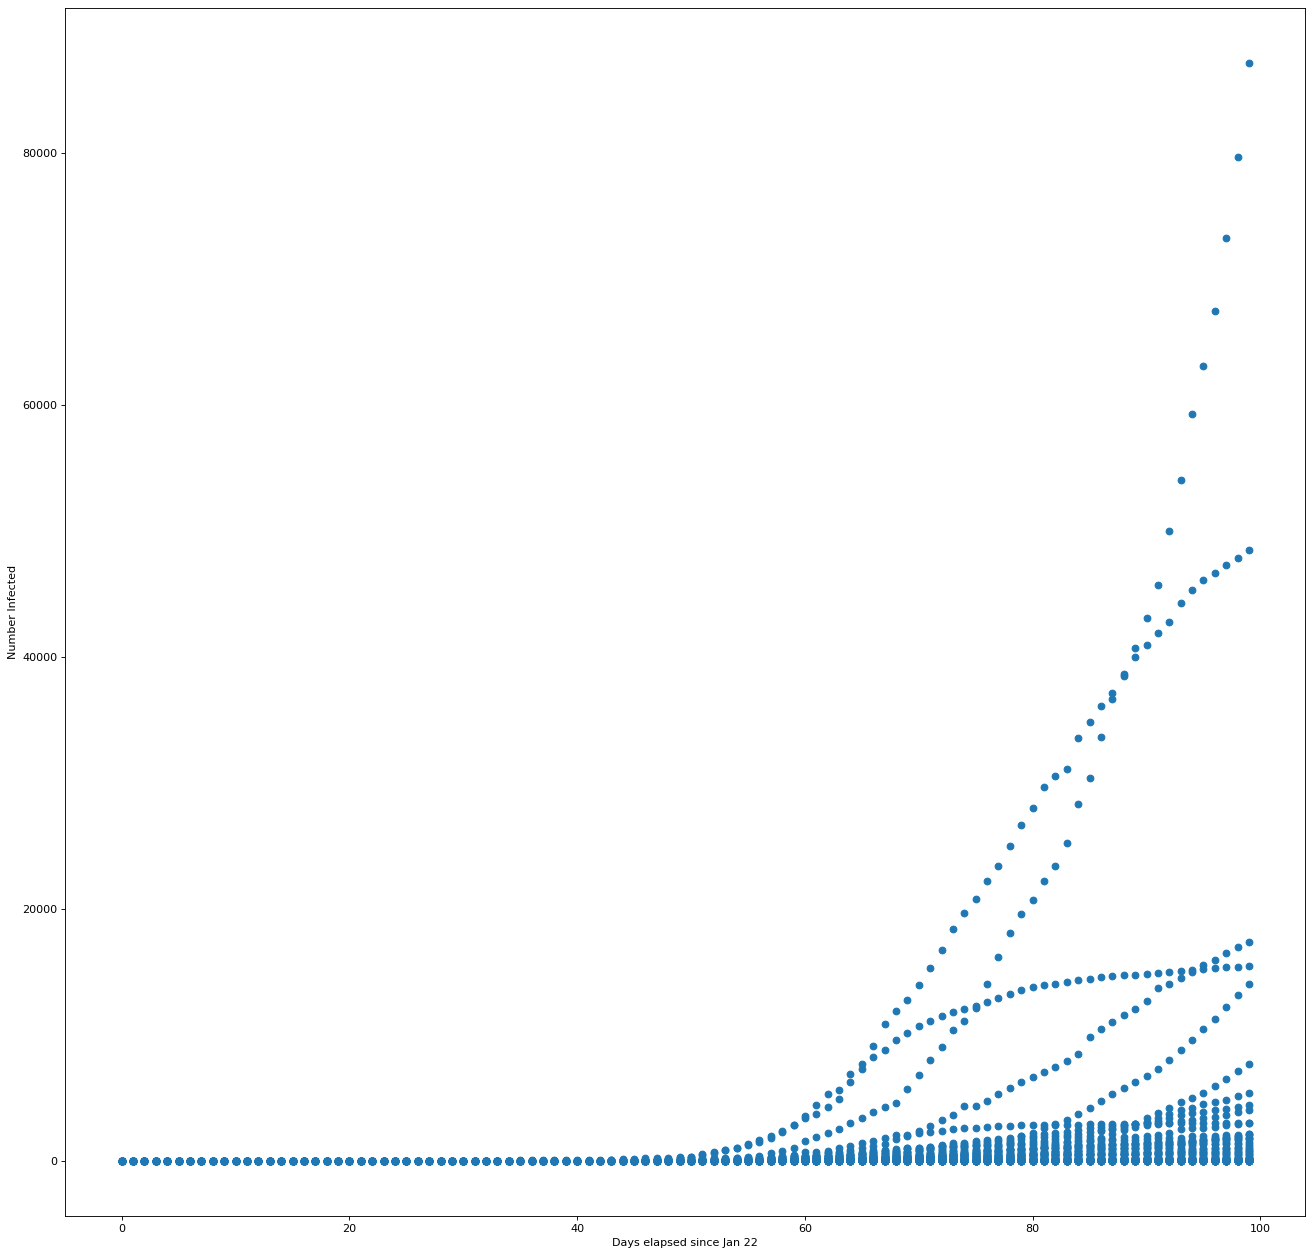

In [35]:
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')
print(np.shape(X))

Spilting the data to training and test (70% train, 30% test)

In [36]:
# Goal 1: Fit regression model for (days vs infections)
from sklearn.model_selection import train_test_split
# Split data into train and test
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Fitting Polynomial features of degree 3 to the features. This results in dimensions going from 3 to 20!

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=22)
# Transform both the train and test data
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
# Fit the model on train data only
clf.fit(X_train, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 2300)
Linear Regression Coefficients are= [[-3.62799155e-32 -1.18619137e-32 -1.03824964e-32 ...  5.30247486e-38
   7.74907999e-39 -3.23323318e-38]]
constant coefficient= [20.7816298]


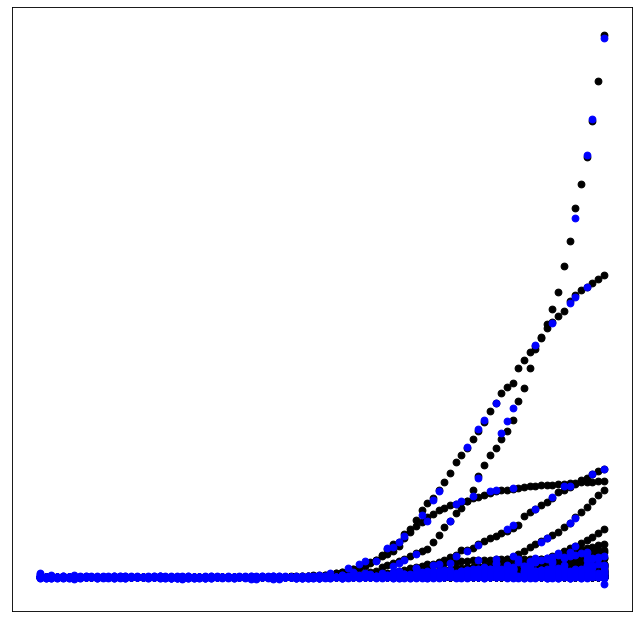

In [38]:
# Predict regression outcome on test data
y_pred = clf.predict(X_test)
# next plot predictions
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In the image above, black points are training and blue ones are test

In [39]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_test, y_pred))

22501.501254423965


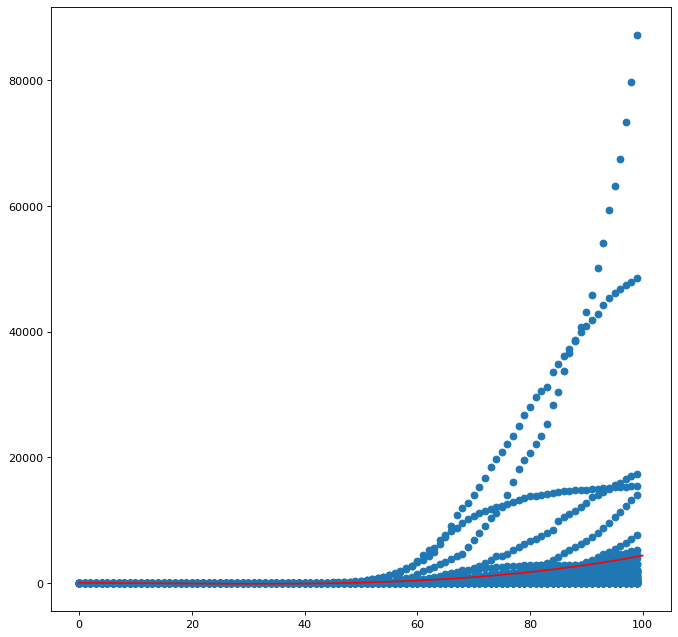

In [40]:
# 1D polynomial regression
model = np.poly1d(np.polyfit(np.transpose(X_train_1[:,2]), np.transpose(y_train[:,0]), 3))

model_x = np.linspace(0, 100, 100)
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.plot(model_x, model(model_x),'r')
plt.show()

In [41]:
from sklearn import metrics
degree = np.arange(3,30)
mse_test = {}
mse_train = {}
for deg in degree:

  poly = PolynomialFeatures(degree=deg)
  # Transform both the train and test data
  X_train = poly.fit_transform(X_train_1)
  X_test = poly.fit_transform(X_test_1)
  print("New shape of test data=",np.shape(X_test))

  clf = LinearRegression()
  # Fit the model on train data only
  clf.fit(X_train, y_train)  #train_X
  y_pred=clf.predict(X_test) #make a predition on test data as usual
  y_pred_train = clf.predict(X_train) #make a prediction on train data in order
  #to check if model underfitting or overfitting with aid of a grah

  mse_lr = round(metrics.mean_squared_error(y_test, y_pred), 4)
  mse_test[deg] = mse_lr
  mse_train[deg] = round(metrics.mean_squared_error(y_train, y_pred_train), 4)

print('degree:mse',mse)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 20)
New shape of test data= (1500, 35)
New shape of test data= (1500, 56)
New shape of test data= (1500, 84)
New shape of test data= (1500, 120)
New shape of test data= (1500, 165)
New shape of test data= (1500, 220)
New shape of test data= (1500, 286)
New shape of test data= (1500, 364)
New shape of test data= (1500, 455)
New shape of test data= (1500, 560)
New shape of test data= (1500, 680)
New shape of test data= (1500, 816)
New shape of test data= (1500, 969)
New shape of test data= (1500, 1140)
New shape of test data= (1500, 1330)
New shape of test data= (1500, 1540)
New shape of test data= (1500, 1771)
New shape of test data= (1500, 2024)
New shape of test data= (1500, 2300)
New shape of test data= (1500, 2600)
New shape of test data= (1500, 2925)
New shape of test data= (1500, 3276)
New shape of test data= (1500, 3654)
New shape of test data= (1500, 4060)
New shape of test data= (1500, 4495)
New shape of test data= (1500, 4960)
degree:mse <functio

In [42]:
mse_test_min = min(mse_test.keys(), key=(lambda k: mse_test[k]))

In [43]:
print('Minimum Value: ',mse_test[mse_test_min], 'Crresponding to degree:', mse_test_min)

Minimum Value:  22501.5013 Crresponding to degree: 22


In [44]:
df1 = pd.DataFrame.from_dict(mse_test,orient = 'index', columns=['mse_test'])
df2 = pd.DataFrame.from_dict(mse_train, orient = 'index', columns=['mse_train'])

In [45]:
df = pd.concat([df1, df2], axis = 1)

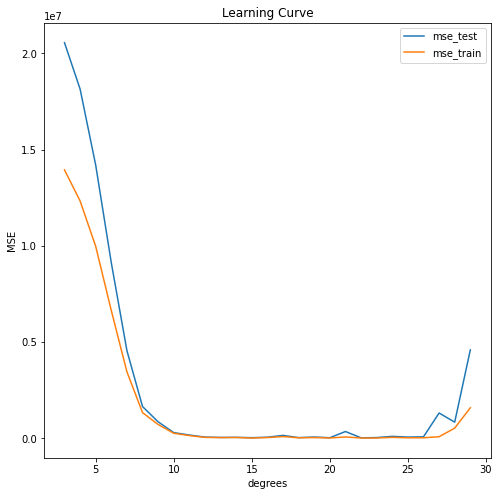

In [46]:
plot=df.plot(figsize=(8,8), title='Learning Curve', xlabel='degrees', ylabel='MSE' )

###Although the minimum mse (22501.5)  happened at degree 22, we can see that both the test and train set stop learning at around 12. The low minimum at 22 could be by chance and crossvalidation could give a better insight on how the best mse could vary between degrees

In [47]:
print('Minimum Value: ',mse_test[mse_test_min], 'Crresponding to degree:', mse_test_min)

Minimum Value:  22501.5013 Crresponding to degree: 22


Modeling with the different polynomial degree

In [48]:
poly = PolynomialFeatures(degree=12)
# Transform both the train and test data
X_train2 = poly.fit_transform(X_train_1)
X_test2 = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf2 = LinearRegression()
# Fit the model on train data only
clf2.fit(X_train2, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 4960)
Linear Regression Coefficients are= [[ 5.64590790e-48 -1.41362559e-48  9.32850747e-48 ... -8.34917288e-51
   4.20242841e-51  2.15922529e-52]]
constant coefficient= [201.35761956]


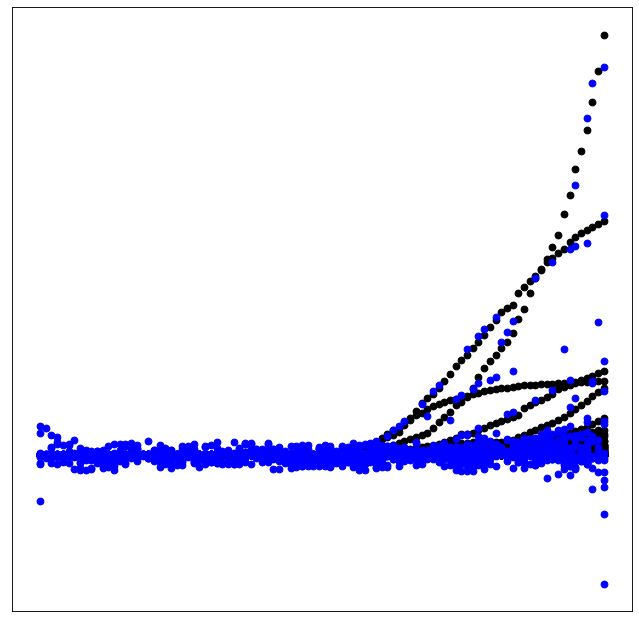

In [49]:
# Predict regression outcome on test data
y_pred2 = clf2.predict(X_test2)
# next plot predictions
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In [50]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_test, y_pred2)) #for degree 22 MSE is 22501

59911.0838300318


Adding a regularization parameter in order to avoid overfitting, although degree 22 gives the minimum cost function (mse), we could be overfitting. We notice that the objective function does not converge after adding the regularization parameter

In [51]:

from sklearn import linear_model
degree = np.arange(3,30)
mse_test = {}
mse_train = {}
for deg in degree:

  poly = PolynomialFeatures(degree=deg)
  # Transform both the train and test data
  X_train = poly.fit_transform(X_train_1)
  X_test = poly.fit_transform(X_test_1)
  print("New shape of test data=",np.shape(X_test))

  clf = linear_model.Lasso()
  # Fit the model on train data only
  clf.fit(X_train, y_train)  #train_X
  y_pred=clf.predict(X_test) #make a predition on test data as usual
  y_pred_train = clf.predict(X_train) #make a prediction on train data in order
  #to check if model underfitting or overfitting

  mse_lr = round(metrics.mean_squared_error(y_test, y_pred), 4)
  mse_test[deg] = mse_lr
  mse_train[deg] = round(metrics.mean_squared_error(y_train, y_pred_train), 4)

print('degree:mse',mse)

New shape of test data= (1500, 20)
New shape of test data= (1500, 35)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24415206463.386894, tolerance: 6124051.488110977
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21631569448.88288, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 56)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19490871145.977768, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 84)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17261175992.66921, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 120)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15649940360.227512, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 165)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14110160188.20187, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 220)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13151386382.738356, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 286)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12491612205.878693, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 364)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11921808729.321608, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 455)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11417852258.402348, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 560)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10852235602.345194, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 680)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10317249514.008732, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 816)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9837415413.088924, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 969)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9430889124.74354, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 1140)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9076850717.22693, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 1330)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8747415927.420387, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 1540)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8428717571.245963, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 1771)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8136563694.7643, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 2024)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7869167165.12344, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 2300)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7637019994.424297, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 2600)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7428200492.48479, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 2925)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7235402788.481304, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 3276)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7061270717.18727, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 3654)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6892783661.894637, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 4060)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6748122026.324509, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 4495)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6608524444.21262, tolerance: 6124051.488110977
  positive)


New shape of test data= (1500, 4960)
degree:mse <function mean_squared_error at 0x7f1978e99680>


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6492870925.327322, tolerance: 6124051.488110977
  positive)


In [52]:
cost_test_min = min(mse_test.keys(), key=(lambda k: mse_test[k]))

In [53]:
print('Minimum Value: ',mse_test[cost_test_min], 'Crresponding to degree:', cost_test_min)

Minimum Value:  6193770.0331 Crresponding to degree: 29


In [54]:
df1 = pd.DataFrame.from_dict(mse_test,orient = 'index', columns=['test'])
df2 = pd.DataFrame.from_dict(mse_train, orient = 'index', columns=['train'])

In [55]:
df = pd.concat([df1, df2], axis = 1)

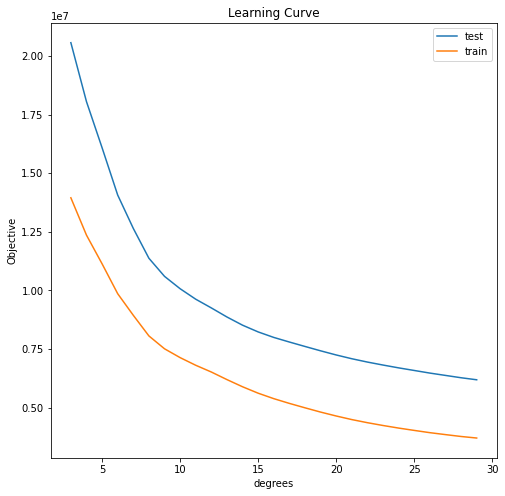

In [56]:
plot=df.plot(figsize=(8,8), title='Learning Curve', xlabel='degrees', ylabel='Objective' )

In [57]:
clf.score(X_test,y_test) #not bad for a score, but the model is underfitting

0.7525481756826771

In [58]:
poly = PolynomialFeatures(degree=26)
# Transform both the train and test data
X_train2 = poly.fit_transform(X_train_1)
X_test2 = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf2 = linear_model.Lasso()
# Fit the model on train data only
clf2.fit(X_train2, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 4960)
Linear Regression Coefficients are= [ 0.00000000e+00  4.52227264e+00  2.36656534e-01 ... -3.93045965e-55
  8.06622428e-55  2.25547659e-55]
constant coefficient= [-47.87553934]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6892783661.894637, tolerance: 6124051.488110977
  positive)


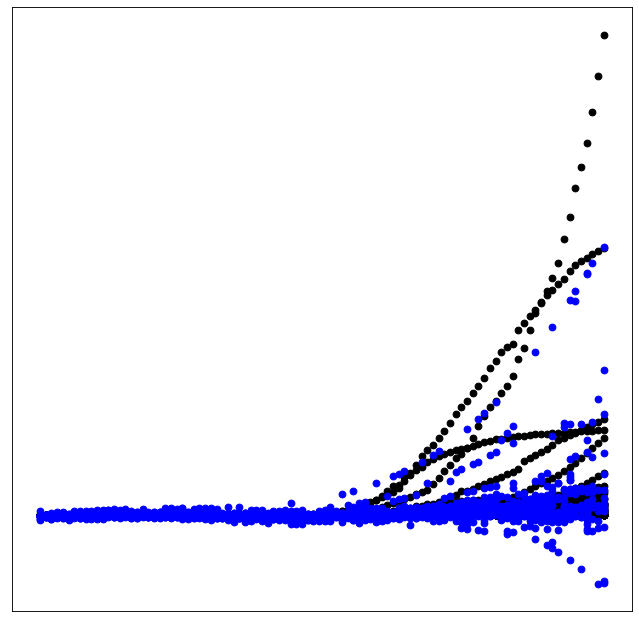

In [59]:
# Predict regression outcome on test data
y_pred2 = clf2.predict(X_test2)
# next plot predictions
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

Now Trying with all of the data

In [60]:
rows=266
cols=255
data_FULL=data.iloc[0:rows,4:cols+4]
print(data_FULL.shape)

(266, 221)


In [61]:
data_row=data_FULL.sum(axis=0)
days=range(0,data_row.shape[0]) # 0 to 100
days_mat=matlib.repmat(np.array(days),data_FULL.shape[0],1)  #repeat 266 times , axis 1
print(days_mat.shape)

(266, 221)


In [62]:
# Let's create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_FULL=np.array(data_FULL)

for r in range(days_mat.shape[0]): #all locations t; days_mat.shape[0]=50   
  # print(np.reshape(days,(days_mat.shape[1],)))

  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude  days_mat.shape[1]=100
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date (arrays of  0 to 100)
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_FULL[r,:],((days_mat.shape[1],1)))

In [63]:
print(np.shape(X))

(58786, 3)


Text(0, 0.5, 'Number Infected')

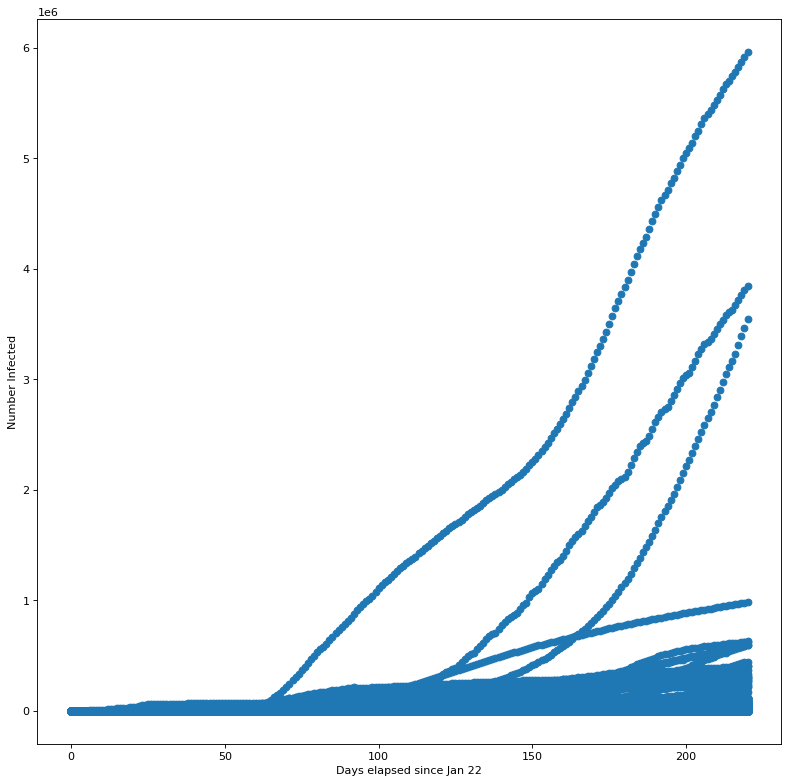

In [64]:
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')


In [65]:
# Goal: Fit regression model for (days vs infections)
# Split data into train and test
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [66]:
from sklearn import metrics
degree = np.arange(3,30)
mse_test1 = {}
mse_train1 = {}
for deg in degree:

  poly = PolynomialFeatures(degree=deg)
  # Transform both the train and test data
  X_train = poly.fit_transform(X_train_1)
  X_test = poly.fit_transform(X_test_1)
  print("New shape of test data=",np.shape(X_test))

  clf = LinearRegression()
  # Fit the model on train data only
  clf.fit(X_train, y_train)  #train_X
  y_pred=clf.predict(X_test) #make a predition on test data as usual
  y_pred_train = clf.predict(X_train) #make a prediction on train data in order
  #to check if model underfitting or overfitting

  mse_lr = round(metrics.mean_squared_error(y_test, y_pred), 4)
  mse_test1[deg] = mse_lr
  mse_train1[deg] = round(metrics.mean_squared_error(y_train, y_pred_train), 4)

print('degree:mse',mse)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (17636, 20)
New shape of test data= (17636, 35)
New shape of test data= (17636, 56)
New shape of test data= (17636, 84)
New shape of test data= (17636, 120)
New shape of test data= (17636, 165)
New shape of test data= (17636, 220)
New shape of test data= (17636, 286)
New shape of test data= (17636, 364)
New shape of test data= (17636, 455)
New shape of test data= (17636, 560)
New shape of test data= (17636, 680)
New shape of test data= (17636, 816)
New shape of test data= (17636, 969)
New shape of test data= (17636, 1140)
New shape of test data= (17636, 1330)
New shape of test data= (17636, 1540)
New shape of test data= (17636, 1771)
New shape of test data= (17636, 2024)
New shape of test data= (17636, 2300)
New shape of test data= (17636, 2600)
New shape of test data= (17636, 2925)
New shape of test data= (17636, 3276)
New shape of test data= (17636, 3654)
New shape of test data= (17636, 4060)
New shape of test data= (17636, 4495)
New shape of test data= (17636

In [67]:
mse_test_min = min(mse_test.keys(), key=(lambda k: mse_test[k]))

In [68]:
print('Minimum Value: ',mse_test[mse_test_min], 'Crresponding to degree:', mse_test_min)

Minimum Value:  6193770.0331 Crresponding to degree: 29


In [69]:
df1 = pd.DataFrame.from_dict(mse_test,orient = 'index', columns=['mse_test'])
df2 = pd.DataFrame.from_dict(mse_train, orient = 'index', columns=['mse_train'])

In [70]:
df = pd.concat([df1, df2], axis = 1)

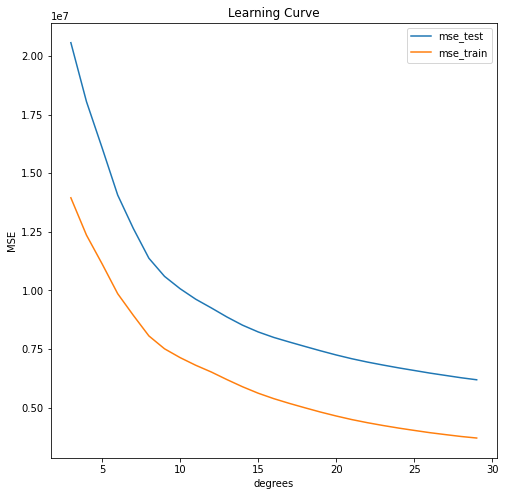

In [71]:
plot=df.plot(figsize=(8,8), title='Learning Curve', xlabel='degrees', ylabel='MSE' )

In [72]:
poly = PolynomialFeatures(degree=22)
# Transform both the train and test data
X_train2 = poly.fit_transform(X_train_1)
X_test2 = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf2 = LinearRegression()
# Fit the model on train data only
clf2.fit(X_train2, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (17636, 4960)
Linear Regression Coefficients are= [[ 1.64433066e-50 -3.31995441e-49 -2.51268008e-50 ... -1.53438353e-57
   3.16164628e-58  2.83598804e-58]]
constant coefficient= [6634.09466981]


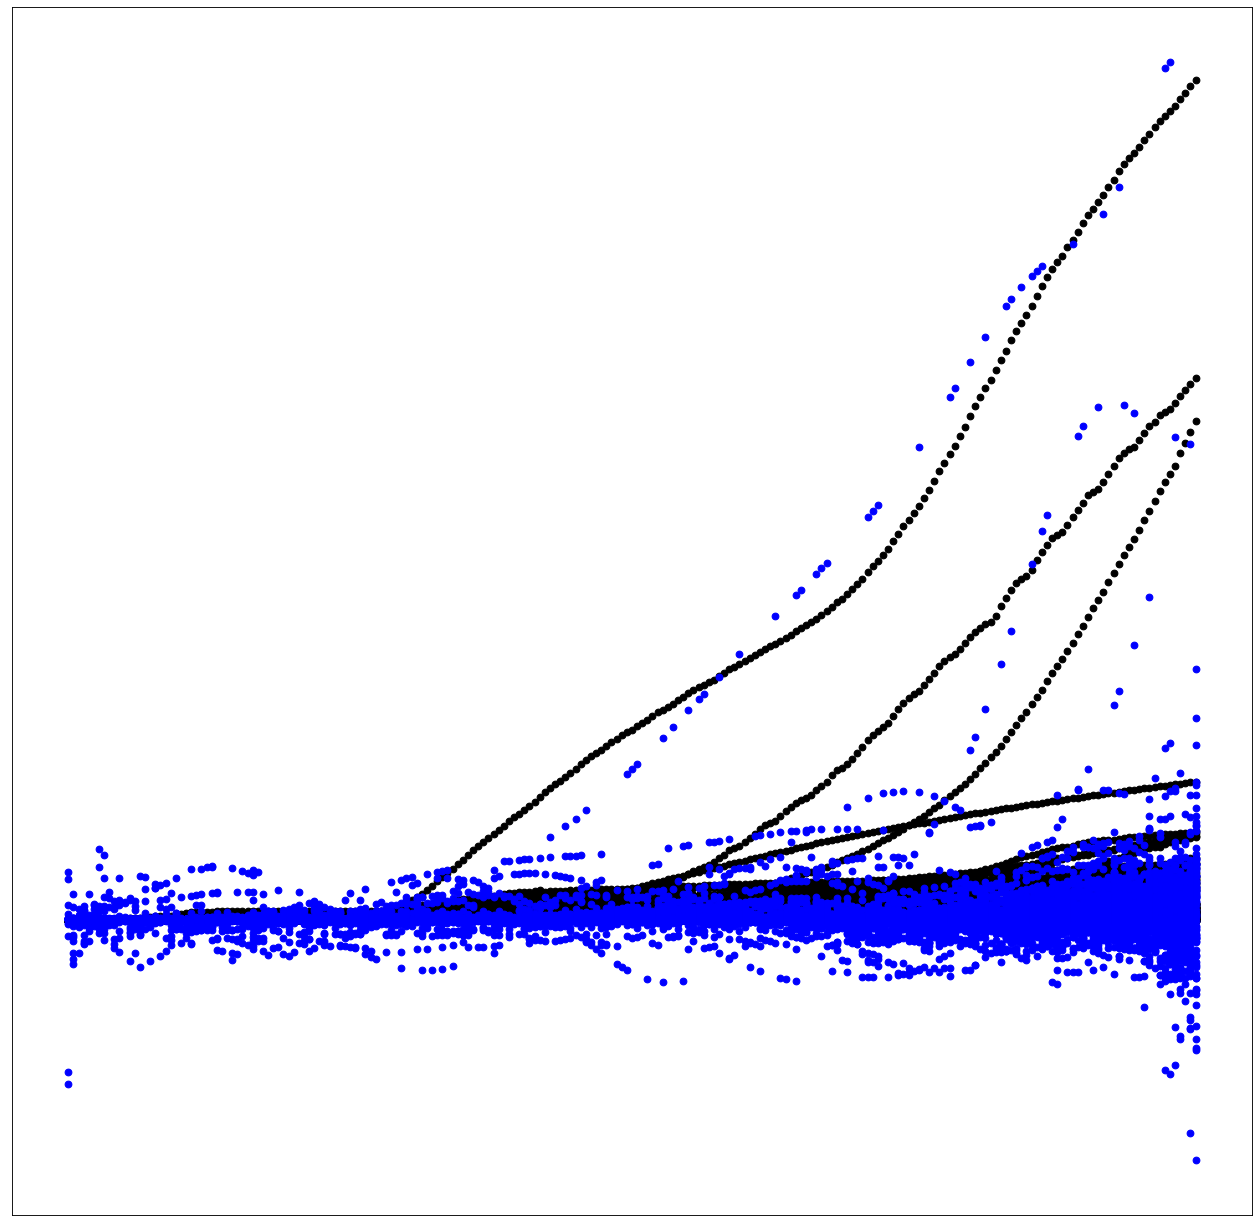

In [73]:
# Predict regression outcome on test data
y_pred2 = clf2.predict(X_test2)
# next plot predictions
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In [84]:
print("Old shape of test data=",np.shape(X_test_1))

Old shape of test data= (17636, 3)


In [92]:
from sklearn import metrics
degree = np.arange(3,30)
mse_test = {}
mse_train = {}
for deg in degree:

  poly = PolynomialFeatures(degree=deg)
  # Transform both the train and test data
  X_train = poly.fit_transform(X_train_1)
  X_test = poly.fit_transform(X_test_1)
  print("New shape of test data=",np.shape(X_test))

  clf = LinearRegression()
  # Fit the model on train data only
  clf.fit(X_train, y_train)  #train_X
  y_pred=clf.predict(X_test) #make a predition on test data as usual
  y_pred_train = clf.predict(X_train) #make a prediction on train data in order
  #to check if model underfitting or overfitting

  mse_lr = round(metrics.mean_squared_error(y_test, y_pred), 4)
  mse_test[deg] = mse_lr
  mse_train[deg] = round(metrics.mean_squared_error(y_train, y_pred_train), 4)

print('degree:mse',mse)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (17636, 20)
New shape of test data= (17636, 35)
New shape of test data= (17636, 56)
New shape of test data= (17636, 84)
New shape of test data= (17636, 120)
New shape of test data= (17636, 165)
New shape of test data= (17636, 220)
New shape of test data= (17636, 286)
New shape of test data= (17636, 364)
New shape of test data= (17636, 455)
New shape of test data= (17636, 560)
New shape of test data= (17636, 680)
New shape of test data= (17636, 816)
New shape of test data= (17636, 969)
New shape of test data= (17636, 1140)
New shape of test data= (17636, 1330)
New shape of test data= (17636, 1540)
New shape of test data= (17636, 1771)
New shape of test data= (17636, 2024)
New shape of test data= (17636, 2300)
New shape of test data= (17636, 2600)
New shape of test data= (17636, 2925)
New shape of test data= (17636, 3276)
New shape of test data= (17636, 3654)
New shape of test data= (17636, 4060)
New shape of test data= (17636, 4495)
New shape of test data= (17636

In [93]:
mse_test

{3: 34001833764.3466,
 4: 33433232649.5069,
 5: 31991022437.6483,
 6: 29944718276.89,
 7: 26809801017.2532,
 8: 21119711070.2937,
 9: 15033013967.2621,
 10: 10280231834.99,
 11: 8146218309.5923,
 12: 5345023199.6508,
 13: 4763359922.3472,
 14: 4201656845.6134,
 15: 4151221457.9133,
 16: 3453357430.1062,
 17: 3813436166.3231,
 18: 3350215570.6484,
 19: 4873865120.6365,
 20: 5831063726.0028,
 21: 4417168768.2386,
 22: 3228544671.4248,
 23: 3354795224.5898,
 24: 4992289911.4924,
 25: 6031734383.6082,
 26: 10850113374.1154,
 27: 13789896911.2939,
 28: 5486593840.733,
 29: 11367303574.049}

In [94]:
df1 = pd.DataFrame.from_dict(mse_test,orient = 'index', columns=['mse_test'])
df2 = pd.DataFrame.from_dict(mse_train, orient = 'index', columns=['mse_train'])


In [95]:
df1.head()

,mse_test
3,3.400183e+10
4,3.343323e+10
5,3.199102e+10
6,2.994472e+10
7,2.680980e+10


In [96]:
df = pd.concat([df1, df2], axis = 1)

In [97]:
df.head()

,mse_test,mse_train
3,3.400183e+10,3.954276e+10
4,3.343323e+10,3.881990e+10
5,3.199102e+10,3.700558e+10
6,2.994472e+10,3.431616e+10
7,2.680980e+10,3.000615e+10


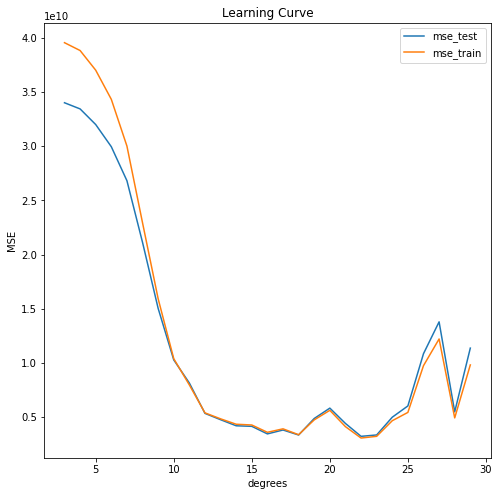

In [98]:
plot=df.plot(figsize=(8,8), title='Learning Curve', xlabel='degrees', ylabel='MSE' )


Both the traing and test curves stop learning at about 10-15 degrees; after 25 one gets erratic behavoir. A better curve would be one that takes crossvalidation into account.  It looks like a good fit until it reaches degree 24 then the mse increases; as the degrees increases the model becomes very specific and wont generalize well; next step: to cross-validate
